# Modeling

We decided to **split the noebooks** in order to be faster, since we don't need graphs anymore.

In [145]:
import pandas as pd

In [146]:
import seaborn as sb
import matplotlib.pyplot as plt


In [147]:
df = pd.read_parquet("https://github.com/maikuvit/Space-Capybaras-Final-Project/raw/main/train_clean.parquet")
df

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtFinSF1,BsmtFullBath,BsmtUnfSF,GarageArea,GrLivArea,LotFrontage,MoSold,...,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker
0,856,854,3,706,1,150,548,1710,65,2,...,False,False,False,False,False,False,False,False,False,False
1,1262,0,3,978,0,284,460,1262,80,5,...,False,False,False,False,False,False,False,False,False,True
2,920,866,3,486,1,434,608,1786,68,9,...,False,False,False,False,False,False,False,False,False,False
3,961,756,3,216,1,540,642,1717,60,2,...,False,False,False,False,False,False,False,False,False,False
4,1145,1053,4,655,1,490,836,2198,84,12,...,True,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,953,694,3,0,0,953,460,1647,62,8,...,False,False,False,False,False,False,False,False,False,False
1456,2073,0,3,790,1,589,500,2073,85,2,...,False,False,False,False,False,False,False,False,False,False
1457,1188,1152,4,275,0,877,252,2340,66,5,...,False,False,False,False,False,False,False,False,False,False
1458,1078,0,2,49,1,0,240,1078,68,4,...,False,False,False,False,False,False,False,False,False,False


# Modeling

In [148]:
from sklearn.model_selection import train_test_split
import numpy as np

x = np.array(df.drop(['SalePrice'], axis=1).values)
y = np.array(df['SalePrice'].values)


seed = 69420
test_size = .3
val_size = .2

#Split train e test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=seed)
#Split train e validation
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_size, random_state=seed)

## Creating models

In [149]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [150]:
rf_model = RandomForestClassifier(random_state=seed)
rf_model.fit(x_train, y_train)
y_pred = rf_model.predict(x_test)

rf_accuracy = accuracy_score(y_test, y_pred)

print("Accuracy: ", accuracy_score(y_test, y_pred))

Accuracy:  0.8721461187214612


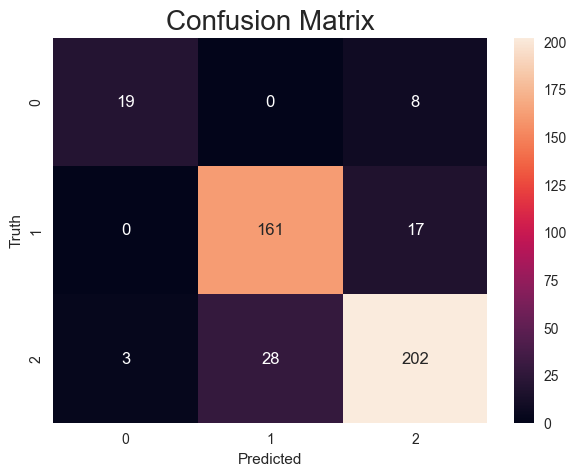

In [151]:
def confusion_matrix_graph(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(7,5))
    sb.heatmap(cm, annot=True, fmt='d', cmap='rocket')
    plt.title("Confusion Matrix", fontsize=20)
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.show()

confusion_matrix_graph(y_test, y_pred)

In [152]:
print(classification_report(y_test, y_pred))
print("Precision is a measure of a classifier’s exactness. The higher the precision, the more accurate the classifier.")
print("Recall is a measure of a classifier’s completeness. The higher the recall, the more cases the classifier covers.")
print("The F1 Score or F-score is a weighted average of precision and recall.")

              precision    recall  f1-score   support

        HIGH       0.86      0.70      0.78        27
         LOW       0.85      0.90      0.88       178
      MEDIUM       0.89      0.87      0.88       233

    accuracy                           0.87       438
   macro avg       0.87      0.83      0.84       438
weighted avg       0.87      0.87      0.87       438

Precision is a measure of a classifier’s exactness. The higher the precision, the more accurate the classifier.
Recall is a measure of a classifier’s completeness. The higher the recall, the more cases the classifier covers.
The F1 Score or F-score is a weighted average of precision and recall.


## Gradient boost


In [153]:
modelGradient = GradientBoostingClassifier(random_state=seed)
modelGradient.fit(x_train, y_train)
y_pred = modelGradient.predict(x_test)

gb_accuracy = accuracy_score(y_test, y_pred)


In [154]:
print("Accuracy: ", accuracy_score(y_test, y_pred))

Accuracy:  0.8744292237442922


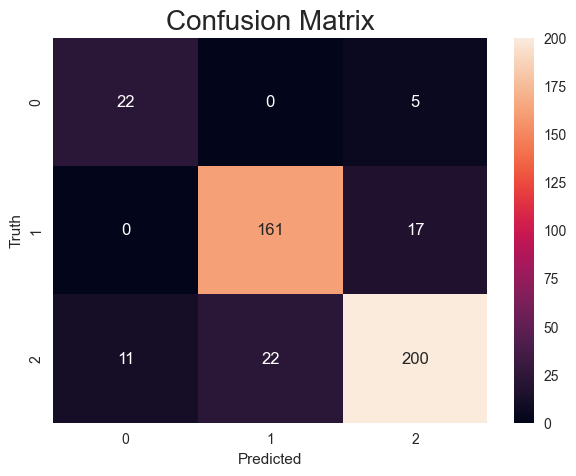

In [155]:
confusion_matrix_graph(y_test, y_pred)

In [156]:
print(classification_report(y_test, y_pred))
print("Precision is a measure of a classifier’s exactness. The higher the precision, the more accurate the classifier.")
print("Recall is a measure of a classifier’s completeness. The higher the recall, the more cases the classifier covers.")
print("The F1 Score or F-score is a weighted average of precision and recall.")

              precision    recall  f1-score   support

        HIGH       0.67      0.81      0.73        27
         LOW       0.88      0.90      0.89       178
      MEDIUM       0.90      0.86      0.88       233

    accuracy                           0.87       438
   macro avg       0.82      0.86      0.83       438
weighted avg       0.88      0.87      0.88       438

Precision is a measure of a classifier’s exactness. The higher the precision, the more accurate the classifier.
Recall is a measure of a classifier’s completeness. The higher the recall, the more cases the classifier covers.
The F1 Score or F-score is a weighted average of precision and recall.


## Adaboost

In [157]:
adaboost_model = AdaBoostClassifier(random_state=seed)
adaboost_model.fit(x_train, y_train)
y_pred = adaboost_model.predict(x_test)

ab_accuracy = accuracy_score(y_test, y_pred)


In [158]:
print("Accuracy: ", accuracy_score(y_test, y_pred))

Accuracy:  0.769406392694064


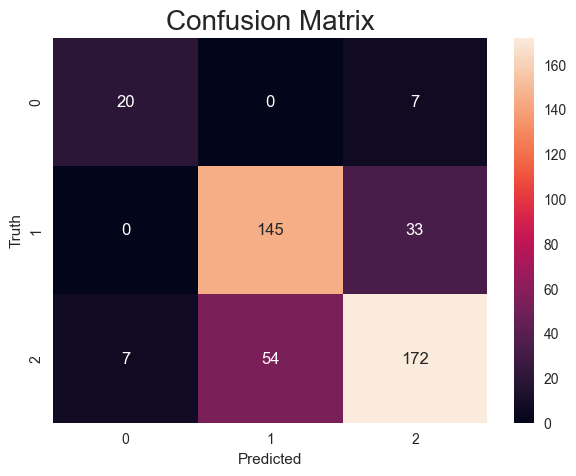

In [159]:
confusion_matrix_graph(y_test, y_pred)

In [160]:
print(classification_report(y_test, y_pred))
print("Precision is a measure of a classifier’s exactness. The higher the precision, the more accurate the classifier.")
print("Recall is a measure of a classifier’s completeness. The higher the recall, the more cases the classifier covers.")
print("The F1 Score or F-score is a weighted average of precision and recall.")

              precision    recall  f1-score   support

        HIGH       0.74      0.74      0.74        27
         LOW       0.73      0.81      0.77       178
      MEDIUM       0.81      0.74      0.77       233

    accuracy                           0.77       438
   macro avg       0.76      0.76      0.76       438
weighted avg       0.77      0.77      0.77       438

Precision is a measure of a classifier’s exactness. The higher the precision, the more accurate the classifier.
Recall is a measure of a classifier’s completeness. The higher the recall, the more cases the classifier covers.
The F1 Score or F-score is a weighted average of precision and recall.


## Hyper Parameter Tuning

### Tuning of RandomForest

In [161]:
from sklearn.model_selection import GridSearchCV

if 1 == 0:
  # Define the parameter grid
  param_grid_rf = {
      'n_estimators': [100, 200, 300],
      'max_depth': [5, 10, 15],
      'min_samples_split': [2, 5, 10],
      'criterion': ['gini', 'entropy'],
      'class_weight': ['balanced', 'balanced_subsample', None],
  }

  # Create the model
  rf_grid_search = RandomForestClassifier(random_state=seed)

  #Split train e test
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=seed)

  # Perform grid search
  grid_search = GridSearchCV(estimator=rf_grid_search, param_grid=param_grid_rf, cv=5, scoring='accuracy')
  grid_search.fit(x_train, y_train)

  # Get the best hyperparameters and model
  best_params = grid_search.best_params_
  best_model = grid_search.best_estimator_

  # Evaluate the best model on the test set
  y_pred = best_model.predict(x_test)

  rftuned_accuracy = accuracy_score(y_test, y_pred)


Random Forest -- Random Search CV


In [162]:
if 1 == 0:
    from sklearn.model_selection import RandomizedSearchCV

    rf_classfier_random = RandomForestClassifier(random_state=seed)
    random_search = RandomizedSearchCV(estimator=rf_classfier_random, param_distributions=param_grid_rf, cv=5, scoring='accuracy' )

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=seed)

    random_search.fit(x_train, y_train)

    best_model = random_search.best_estimator_
    best_params = random_search.best_params_

    y_pred = best_model.predict(x_test)

    rf_random_accuracy = accuracy_score(y_test, y_pred)

In [163]:
if 1 == 0:

  # Define the model names
  model_names = ['RandomForest', 'RandomForestTuned', 'RandomForestRandom']

  # Define the accuracy scores
  accuracy_scores = [rf_accuracy, rftuned_accuracy, rf_random_accuracy]

  # Create the bar plot using seaborn 
  plt.figure(figsize=(7,5))
  sb.barplot(x=model_names, y=accuracy_scores)

  #add the the value on the top of each bar
  for i in range(len(accuracy_scores)):
      plt.text(i, accuracy_scores[i], round(accuracy_scores[i], 4), ha = 'center', fontsize = 15)

  # Add labels and title
  plt.title("Accuracy scores of the models", fontsize=20)
  plt.xlabel("Model", fontsize=15)
  plt.ylabel("Accuracy score", fontsize=15)
  plt.ylim(0.5, 1)

  # Show the plot
  plt.show()

### Gradient Boost Hypertuning

Grid Search CV

In [164]:
if 1 == 0:
    #very slow
  param_grid_gb = {
      'learning_rate': [0.1, 0.05, 0.01],
      'n_estimators': [100, 200, 300],
      'max_depth': [3, 4, 5],
  }

  gb_classifier = GradientBoostingClassifier(random_state=seed)
  grid_search = GridSearchCV(estimator=gb_classifier, param_grid=param_grid_gb, cv=5)

  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=seed)

  grid_search.fit(x_train, y_train)

  best_model = grid_search.best_estimator_
  best_params = grid_search.best_params_

  y_pred = best_model.predict(x_test)

  gbtuned_accuracy = accuracy_score(y_test, y_pred)

Random Search CV

In [165]:
if 1 == 0:
  gb_classifier_random = GradientBoostingClassifier(random_state=seed)
  random_search = RandomizedSearchCV(estimator=gb_classifier_random, param_distributions=param_grid_gb, cv=5)

  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=seed)

  random_search.fit(x_train, y_train)

  best_model = random_search.best_estimator_
  best_params = random_search.best_params_

  y_pred = best_model.predict(x_test)

  gbrandom_accuracy = accuracy_score(y_test, y_pred)

Gradient Boost Hypertuning Comparison

In [166]:
if 1 == 0:
  # Define the model names
  model_names = ['GradientBoosting', 'GradientBoostingTuned', 'GradientBoostRandom']

  # Define the accuracy scores
  accuracy_scores = [gb_accuracy, gbtuned_accuracy, gbrandom_accuracy]

  # Create the bar plot using seaborn
  plt.figure(figsize=(8,6))
  sb.barplot(x=model_names, y=accuracy_scores)

  # Add the the value on the top of each bar
  for i in range(len(accuracy_scores)):
      plt.text(i, accuracy_scores[i], round(accuracy_scores[i], 4), ha = 'center', fontsize = 15)

  # Add labels and title
  plt.title("Accuracy scores of the models", fontsize=20)

  plt.xlabel("Model", fontsize=15)
  plt.ylabel("Accuracy score", fontsize=15)
  plt.ylim(0.5, 1)

  # Show the plot
  plt.show()


### Cross Validation 

In [167]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(rf_model, x, y, cv=5)
print(scores)
print(f"Model Random Forest{scores.mean()} is the mean accuracy and {scores.std()} is the standard deviation")

[0.89041096 0.87328767 0.84589041 0.90410959 0.88356164]
Model Random Forest0.8794520547945206 is the mean accuracy and 0.01954156522970833 is the standard deviation


In [168]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(modelGradient, x, y, cv=5)
print(scores)
print(f"Model GradientBoost: {scores.mean()} is the mean accuracy and {scores.std()} is the standard deviation")

[0.86643836 0.85616438 0.85273973 0.8869863  0.86986301]
Model GradientBoost: 0.8664383561643835 is the mean accuracy and 0.012059463603876044 is the standard deviation


### Plotting importances

<Axes: ylabel='importance'>

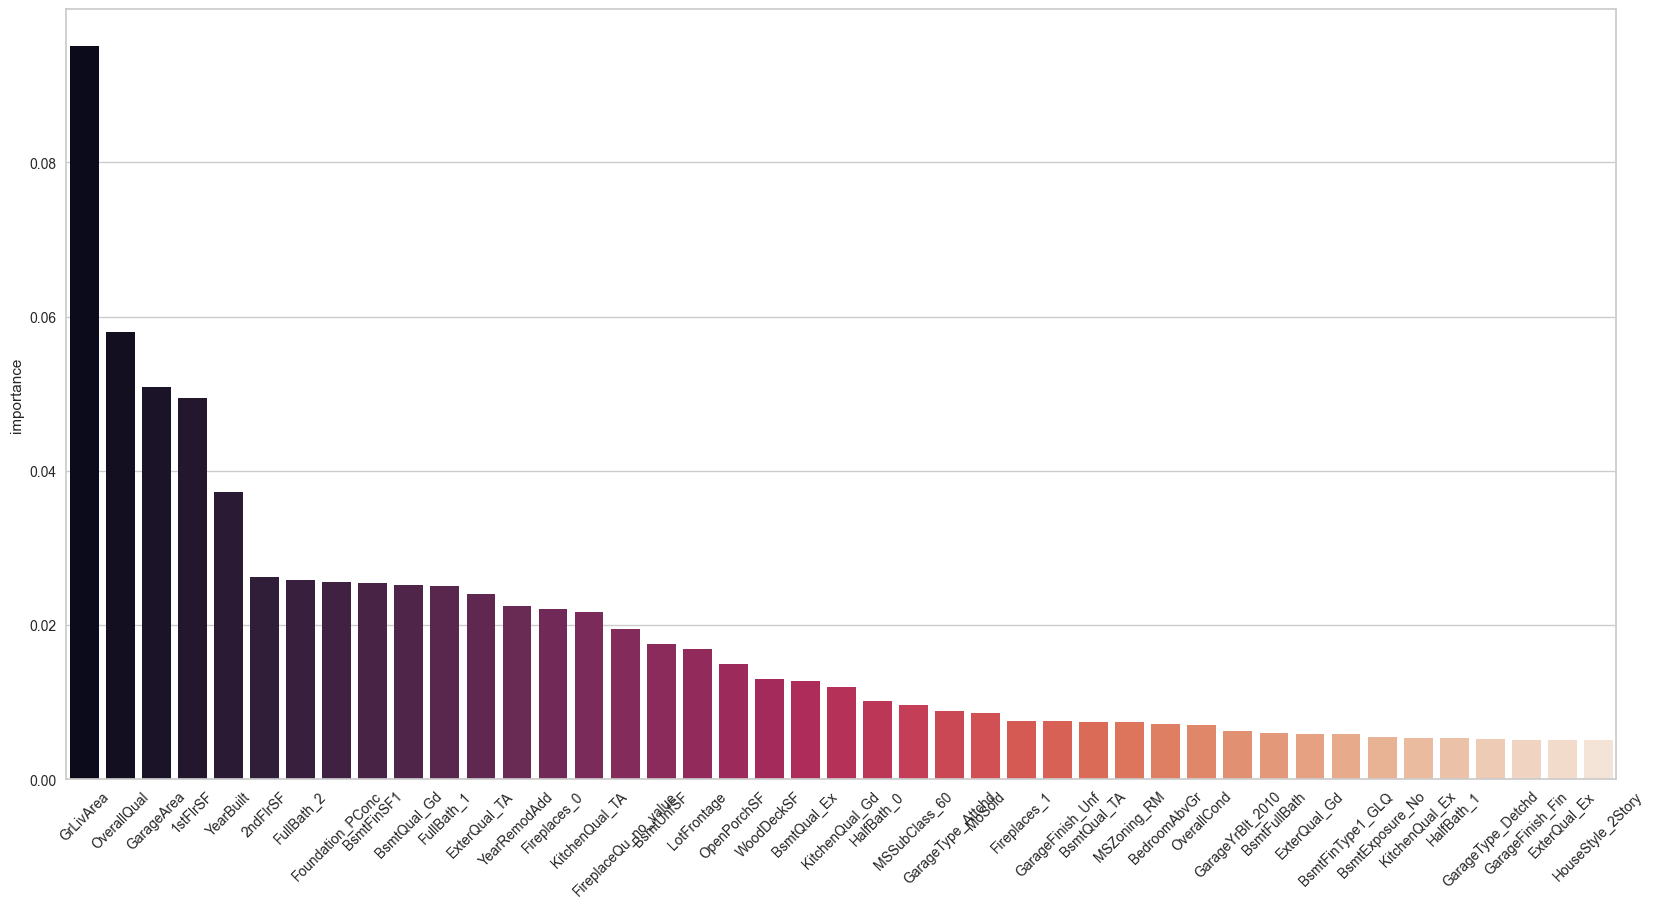

In [169]:
importances = rf_model.feature_importances_   
importances = pd.DataFrame(importances, index = df.drop(['SalePrice'], axis=1).columns, columns=['importance']).sort_values('importance', ascending=False)

importances = importances[importances['importance'] > 0.005]
plt.figure(figsize=(20,10))
plt.xticks(rotation=45)
sb.barplot(x=importances.index, y=importances['importance'], palette="rocket")

### All models with new features

In [170]:
models = []
models.append(('RandomForest', RandomForestClassifier(random_state=seed)))
models.append(('GradientBoosting', GradientBoostingClassifier(random_state=seed)))
models.append(('AdaBoost', AdaBoostClassifier(random_state=seed)))

results = []


df2 = df[importances.index]


x2 = np.array(df2.values)
y2 = np.array(df['SalePrice'].values)

x_train, x_test, y_train, y_test = train_test_split(x2, y2, test_size=test_size, random_state=seed)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_size, random_state=seed)

In [171]:
for name, model in models:
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    results.append(accuracy_score(y_test, y_pred))
    print(name, accuracy_score(y_test, y_pred))

RandomForest 0.8926940639269406
GradientBoosting 0.865296803652968
AdaBoost 0.7922374429223744


### Al confusion matrixes

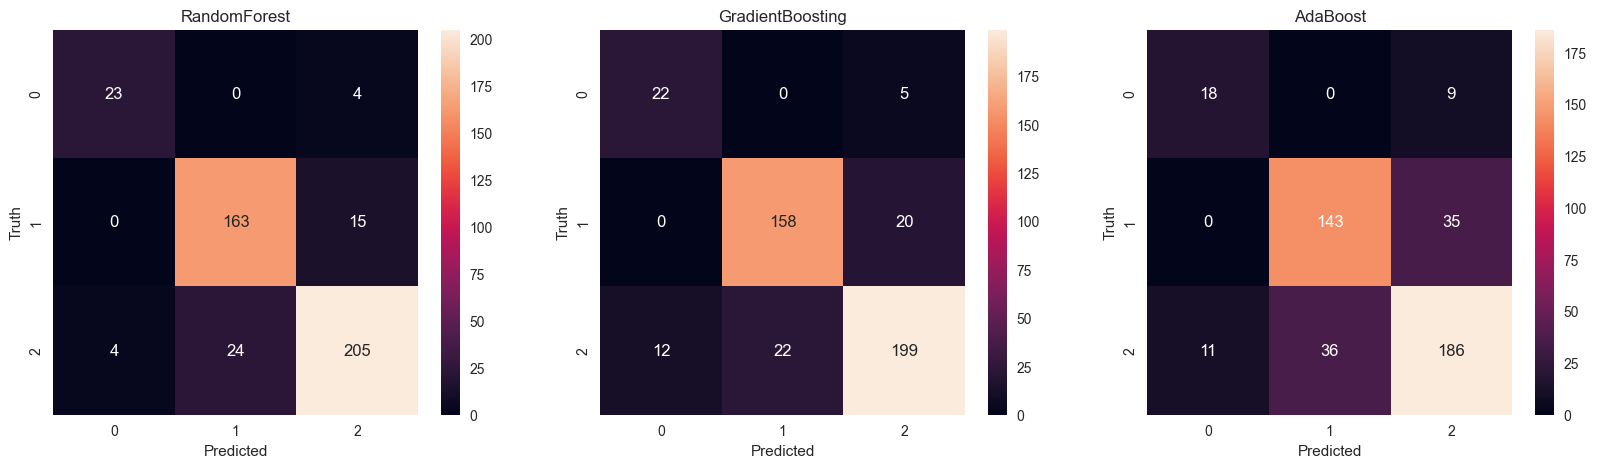

In [172]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
for i, (name, model) in enumerate(models):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    cm = confusion_matrix(y_test, y_pred)
    sb.heatmap(cm, annot=True, fmt='d', cmap='rocket', ax=axes[i])
    axes[i].set_title(name)
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Truth')

### Something to do

* SVC 
* Cross Validation
* Logit Regres
* MLP


# Model Evaluation

Evaluating the model without features selection

In [177]:
#split data into train and test

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=seed)
rf_model.fit(x_train, y_train)
modelGradient.fit(x_train, y_train)
adaboost_model.fit(x_train, y_train)

rf_pred = rf_model.predict(x_test)

### ROC

When computing multiclass, we need probabilities scores that sums up to 1 for each line. 

Example: [0.02, 0.23, 0.75],

In [174]:

rf_pred_prob = rf_model.predict_proba(x_test)
rf_pred_prob


array([[0.  , 0.91, 0.09],
       [0.02, 0.23, 0.75],
       [0.09, 0.04, 0.87],
       ...,
       [0.04, 0.  , 0.96],
       [0.  , 0.56, 0.44],
       [0.  , 0.94, 0.06]])

In [269]:
from sklearn.metrics import roc_curve, auc#OVR means One class against the rest

In [216]:
one_hot_encoding = np.array(pd.get_dummies(y_test, columns = ['SalePrice']))
one_hot_encoding

array([[0, 1, 0],
       [0, 0, 1],
       [0, 0, 1],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 1, 0]], dtype=uint8)

In [217]:
probs = []

for _, model in models:
    model.fit(x_train, y_train)
    probs.append(model.predict_proba(x_test))


In [265]:

plt.style.use('seaborn-v0_8-deep')

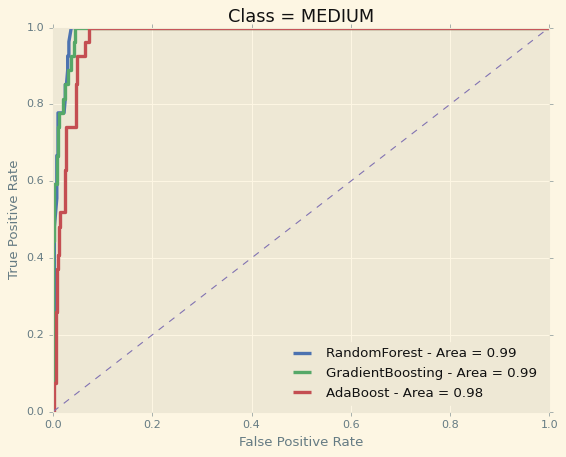

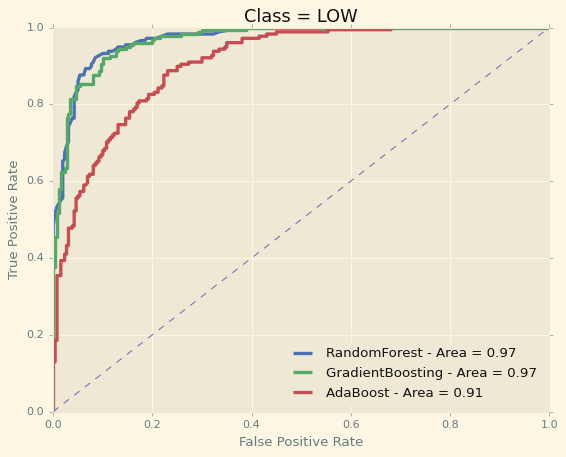

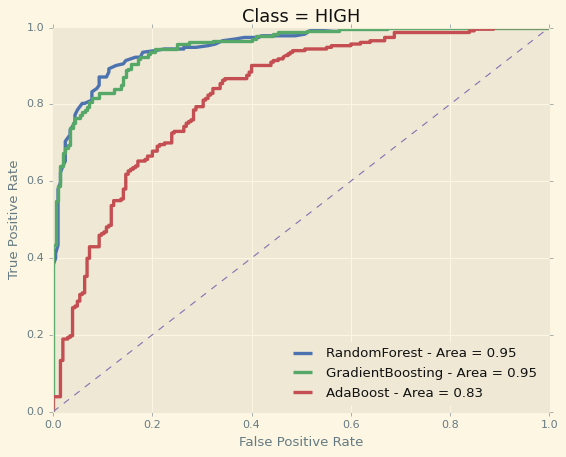

In [268]:
falsepositiverate = dict()
truepositiverate = dict()
roc_auc = dict()

for i in range(len(np.unique(y))):
    plt.figure()
    m = 0
    for name, _ in models:
        falsepositiverate[i], truepositiverate[i], _ = roc_curve(one_hot_encoding[:,i], probs[m][:,i])

        roc_auc[i] = auc(falsepositiverate[i], truepositiverate[i])
        
        plt.plot(falsepositiverate[i], truepositiverate[i], lw=3, label=f"{name} - Area = {roc_auc[i]:.2f}")
        m += 1
    
    plt.plot([0, 1], [0, 1], lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')    
    plt.title(f'Class = {str(np.unique(y)[2-i])}')
    plt.legend(loc='lower right')

    plt.show()
